<a href="https://colab.research.google.com/github/jhlee508/Colab/blob/master/naver_stock_price_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **RNN(Recurrent Neural Networks)/LSTM(Long Short Term Memory) 순환신경망을 사용하여 Naver Corporation(네이버)의 주식 가격을 예측하는 모델을 만들어본다.**


# **Library import**

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

# **Load Dataset**

In [2]:
from google.colab import files
files.upload()

Saving naver.csv to naver.csv


{'naver.csv': b'Date,Open,High,Low,Close,Adj Close,Volume\r\n2016-04-18,133600,134400,131400,132200,130978.7344,374705\r\n2016-04-19,132200,134400,132200,133800,132563.9375,451405\r\n2016-04-20,133200,133600,130200,130800,129591.6641,463915\r\n2016-04-21,132000,133400,131200,133400,132167.6563,412070\r\n2016-04-22,132000,133000,131400,132600,131375.0313,194870\r\n2016-04-25,132400,133000,131000,132400,131176.875,355620\r\n2016-04-26,132600,134400,129800,130800,129591.6641,789600\r\n2016-04-27,129600,133000,128000,133000,131771.3438,403340\r\n2016-04-28,138200,138200,129200,131800,130582.4141,1141055\r\n2016-04-29,133600,136200,133200,135400,134149.1875,908665\r\n2016-05-02,135800,136000,133400,135600,134347.3125,288895\r\n2016-05-03,136400,136400,135000,135200,133951.0156,343900\r\n2016-05-04,135800,136600,134000,136000,134743.625,697250\r\n2016-05-09,139800,141000,137400,140000,138706.6875,925425\r\n2016-05-10,141600,142800,139000,141400,140093.7188,532275\r\n2016-05-11,140000,140400,

In [114]:
data = pd.read_csv('naver.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-18,133600.0,134400.0,131400.0,132200.0,130978.7344,374705.0
1,2016-04-19,132200.0,134400.0,132200.0,133800.0,132563.9375,451405.0
2,2016-04-20,133200.0,133600.0,130200.0,130800.0,129591.6641,463915.0
3,2016-04-21,132000.0,133400.0,131200.0,133400.0,132167.6563,412070.0
4,2016-04-22,132000.0,133000.0,131400.0,132600.0,131375.0313,194870.0


- Open(시가): 주식에서 처음 거래된 가격(우리나라 오전 9시)
- Close(종가): 당일 맨 마지막 거래가 체결된 가격(우리나라 오후 3시)
- High/Low: 최고거래가/최저거래가
- Adj Close: 수정 종가라는 뜻으로 분할, 배당, 배분, 신주 발생이 된 경우를 고려해 주식 가격을 조정(adjustment)해둔 가격
- Volume: 주식거래량



# **Data preprocessing**

In [117]:
# 데이터 개수 파악
data.count()

Date         1227
Open         1222
High         1222
Low          1222
Close        1222
Adj Close    1222
Volume       1222
dtype: int64

In [118]:
# 결측치 개수 파악
data.isnull().sum()

Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [119]:
# 결측치가 있는 행 제거
data = data.dropna()
data.count()

Date         1222
Open         1222
High         1222
Low          1222
Close        1222
Adj Close    1222
Volume       1222
dtype: int64

In [120]:
# 고가와 저가의 중간 가격 구하기
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# **Visualize time series data**

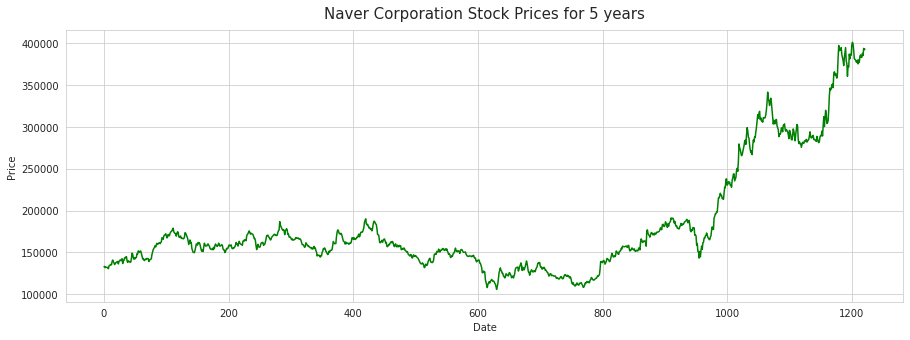

In [158]:
# 그래프로 시각화 해보기
sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
plt.plot(mid_prices, c = 'g')
plt.title("Naver Corporation Stock Prices for 5 years", size = 15, y = 1.02)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# **Create Windows**
- Window Size = 50 + 1
- 첫 번째 window는 50일 치의 값으로 그 다음 날의 값을 예측한다. 
- 그리고 두 번째 window는 하루 씩 밀려서 첫 날의 그 다음 날부터 50일치의 값으로 그 다음 날의 값을 예측한다. 
- 이러한 과정을 반복한다.

In [123]:
n_steps = 50 # time step = 50 
sequence_length = n_steps + 1 # 총 window size

# 리스트 생성
series = [] 

# result 리스트는 index 별로 51일치의 data가 들어감. 총 길이는 전체에서 51일을 뺀 값
for index in range(len(mid_prices) - sequence_length):
    series.append(mid_prices[index:index + sequence_length])

In [124]:
len(series[0])

51

In [125]:
len(series)

1171

# **Normalize Data**

In [126]:
normalized_data = []
window_mean = []
window_std = []

# Z-Score Normalization
for window in series:
    normalized_window = [((p - np.mean(window))/np.std(window)) for p in window]
    normalized_data.append(normalized_window) 
    window_mean.append(np.mean(window))
    window_std.append(np.std(window))

# 여기서 result는 Z-Score Normalization 되어진 dataset
series = np.array(normalized_data)

# **Train Valid Test split**

In [141]:
# 전체를 7:2:1 으로 분할
row1 = int(round(series.shape[0] * 0.7))
row2 = int(round(series.shape[0] * 0.2))
print(row1, row2, len(series) - (row1+row2))

820 234 117


In [142]:
# train, valid, test 분할
X_train, y_train = series[:row1, :n_steps], series[:row1, -1]
X_valid, y_valid = series[row1:row1+row2, :n_steps], series[row1:row1+row2, -1]
X_test, y_test = series[row1+row2:, :n_steps], series[row1+row2:, -1]

In [143]:
X_train.shape, y_train.shape

((820, 50), (820,))

In [144]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train.shape, y_train.shape

((820, 50, 1), (820, 1))

- 학습데이터: 배치 사이즈 = 820, 타입 스텝 수 = 50, 단변량 값

# **Build a Model**

In [192]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


# **Training**

In [193]:
model.fit(X_train, y_train, 
          epochs=15,
          validation_data=(X_valid, y_valid))

Epoch 1/15
26/26 [==============================] - 5s 77ms/step - loss: 1.4075 - val_loss: 0.6647
Epoch 2/15
26/26 [==============================] - 1s 48ms/step - loss: 0.5701 - val_loss: 0.5048
Epoch 3/15
26/26 [==============================] - 1s 48ms/step - loss: 0.4722 - val_loss: 0.4062
Epoch 4/15
26/26 [==============================] - 1s 48ms/step - loss: 0.3738 - val_loss: 0.3166
Epoch 5/15
26/26 [==============================] - 1s 52ms/step - loss: 0.2930 - val_loss: 0.2709
Epoch 6/15
26/26 [==============================] - 1s 47ms/step - loss: 0.2162 - val_loss: 0.2572
Epoch 7/15
26/26 [==============================] - 1s 48ms/step - loss: 0.1949 - val_loss: 0.2060
Epoch 8/15
26/26 [==============================] - 1s 46ms/step - loss: 0.1590 - val_loss: 0.2076
Epoch 9/15
26/26 [==============================] - 1s 46ms/step - loss: 0.1555 - val_loss: 0.1960
Epoch 10/15
26/26 [==============================] - 1s 47ms/step - loss: 0.1493 - val_loss: 0.1925
Epoch 11/

# **Prediction**

In [194]:
# 테스트 데이터 평가
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 12ms/step - loss: 0.2633


0.26333382725715637

In [195]:
# 예측값 구하기
predicted = model.predict(X_test)

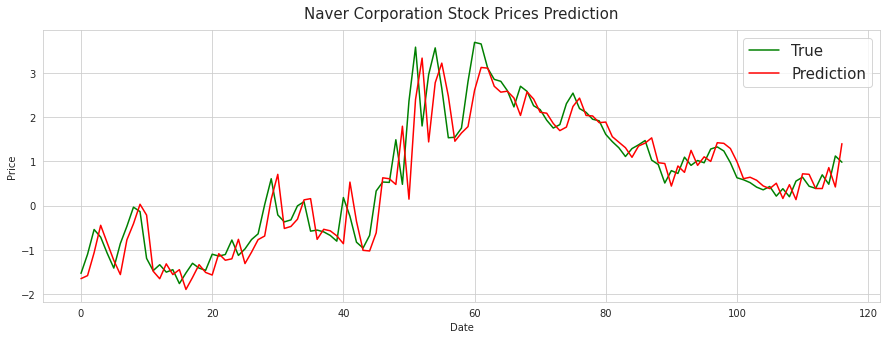

In [196]:
# 시각화
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True', c = 'g')
plt.plot(predicted, label='Prediction', c = 'r')
plt.title("Naver Corporation Stock Prices Prediction", size = 15, y = 1.02)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(fontsize = 15)
plt.show()